<a href="https://colab.research.google.com/github/Vijay-K-2003/Deep_Learning_Models/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 44.3 MB/s eta 0:00:00


In [2]:
import lightning as L

import torch
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split

from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

import os

In [3]:
random_seed = 42
torch.manual_seed(random_seed)

In [6]:
BATCH_SIZE = 128
NUM_WORKERS = int(os.cpu_count()/2)
AVAILABLE_GPUS = torch.cuda.device_count()

In [7]:
class MNISTDataModule(L.LightningDataModule):

    def __init__(self,
                 data_dir="./data",
                 batch_size=BATCH_SIZE,
                 num_workers=NUM_WORKERS) -> None:
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage: str) -> None:
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return torch.sigmoid(x)

In [9]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2)
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2)
        self.conv = nn.Conv2d(16, 1, kernel_size=7)

    def forward(self, x):
        # Latent Space to Linear Layer and Reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)
        # Upsample 16*16 : 64 feature maps
        x = F.relu(self.ct1(x))
        # Upsample 34*34 : 16 feature maps
        x = F.relu(self.ct2(x))
        # Convolution to 28*28 : 1 feature map
        return self.conv(x)

In [21]:
class GAN(L.LightningModule):
    def __init__(self,
                 latent_dim=100,
                 lr=0.0002):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False

        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()

        # Random Noise to test the images.
        self.validation_z = torch.randn(6, self.hparams.latent_dim)

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, predicted_labels, actual_labels):
        return F.binary_cross_entropy(predicted_labels, actual_labels)

    def training_step(self, batch, batch_idx):
        real_imgs, _ = batch
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(real_imgs)

        opt_g, opt_d = self.optimizers()

        opt_g.zero_grad()
            # Generator: Maximize log(D(G(z)))
        fake_imgs = self(z)
        predicted_labels = self.discriminator(fake_imgs)
        actual_labels = torch.ones(real_imgs.size(0), 1).type_as(real_imgs)
        g_loss = self.adversarial_loss(predicted_labels, actual_labels)
        self.log("g_loss", g_loss, prog_bar=True)
        self.manual_backward(g_loss)
        opt_g.step()

        opt_d.zero_grad()
        # Discriminator : Maximize log(D(x)) + log(1-D(G(x)))
        # How well can the Discriminator label as real
        real_predicted_labels = self.discriminator(real_imgs)
        actual_labels = torch.ones(real_imgs.size(0), 1).type_as(real_imgs)
        d_loss_real = self.adversarial_loss(real_predicted_labels, actual_labels)
        # How well can the Discriminator label as fake
        fake_imgs = self(z).detach()
        fake_predicted_labels = self.discriminator(fake_imgs)
        actual_labels = torch.zeros(real_imgs.size(0), 1).type_as(real_imgs)

        d_loss_fake = self.adversarial_loss(fake_predicted_labels, actual_labels)
        d_loss = (d_loss_real + d_loss_fake) / 2
        self.log("d_loss", d_loss, prog_bar=True)
        self.manual_backward(d_loss)
        opt_d.step()


    def configure_optimizers(self):
        lr = self.hparams.lr

        opt_g = optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = optim.Adam(self.discriminator.parameters(), lr=lr)

        return [opt_g, opt_d], []

    def plot_images(self):
        z = self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()

        print("Epoch ", self.current_epoch)
        fig = plt.figure()
        for i in range(sample_imgs.size(0)):
            plt.subplot(2, 3, i+1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach().numpy()[i, 0, :, :], cmap="gray_r", interpolation=None)
            plt.title("Generated Data")
            plt.xticks([])
            plt.yticks([])
        plt.show()

    def on_train_epoch_end(self):
        self.plot_images()


In [22]:
dm = MNISTDataModule()
model = GAN()

Epoch  0


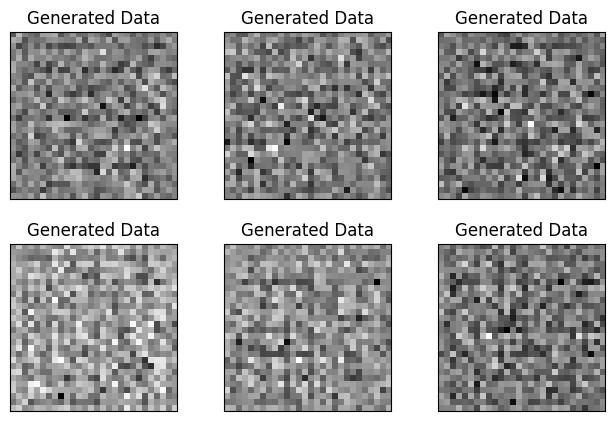

In [23]:
model.plot_images()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 358 K  | train
1 | discriminator | Discriminator | 21.4 K | train
--------------------------------------------------------
379 K     Trainable params
0        

Training: |          | 0/? [00:00<?, ?it/s]

Epoch  0


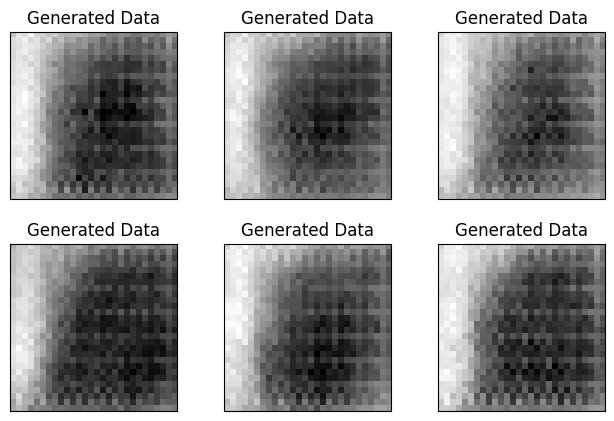

Epoch  1


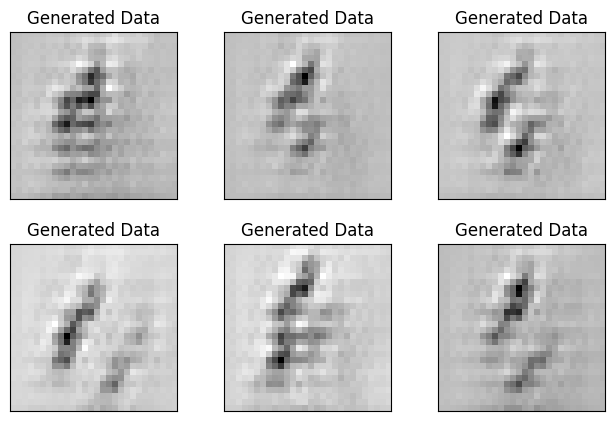

Epoch  2


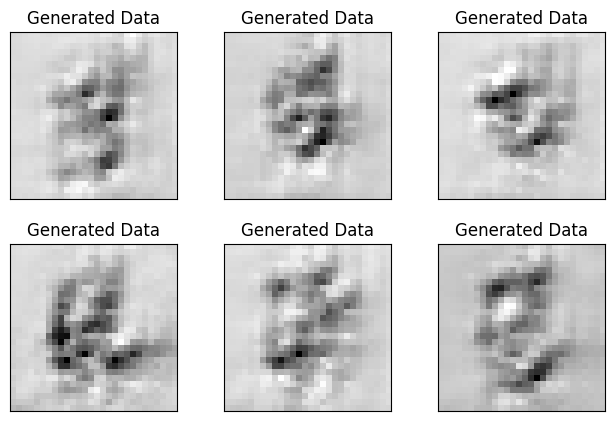

Epoch  3


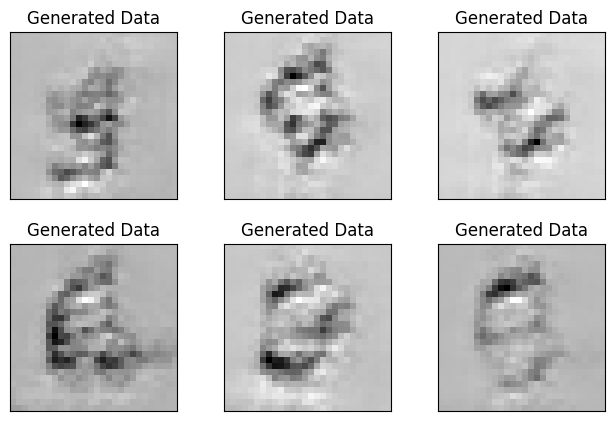

Epoch  4


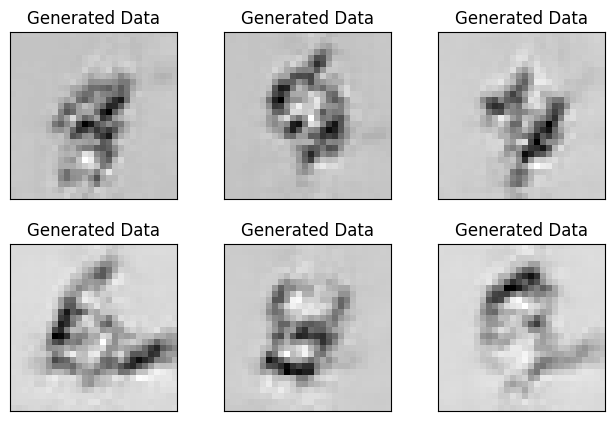

Epoch  5


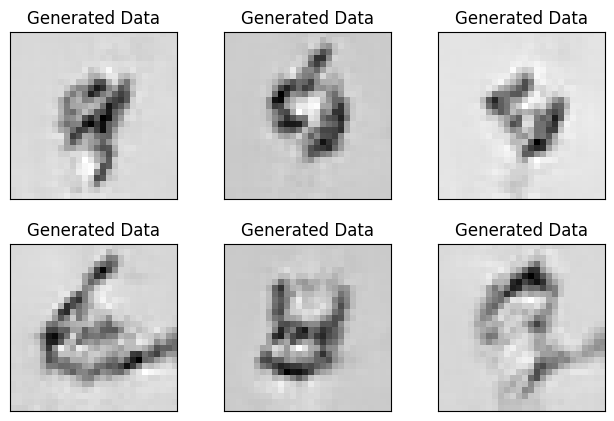

Epoch  6


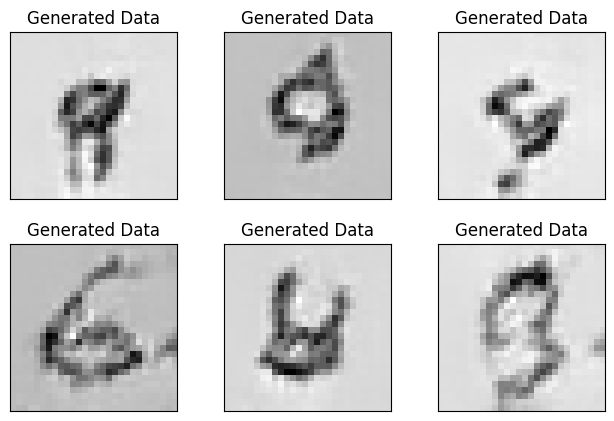

Epoch  7


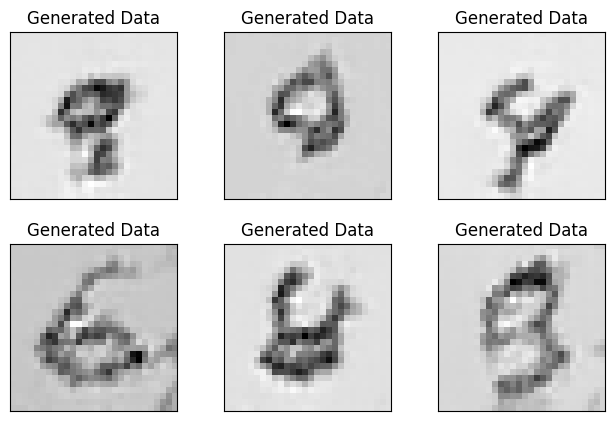

Epoch  8


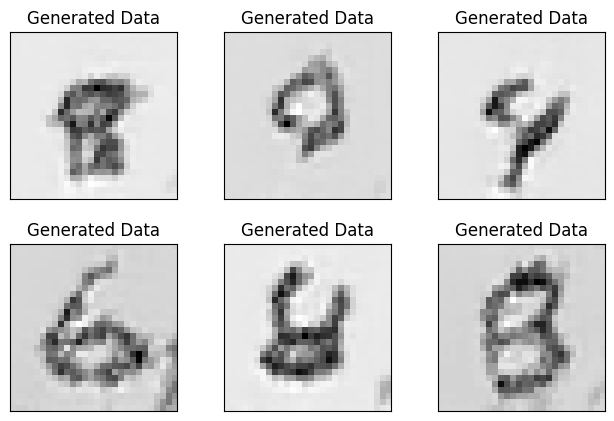

Epoch  9


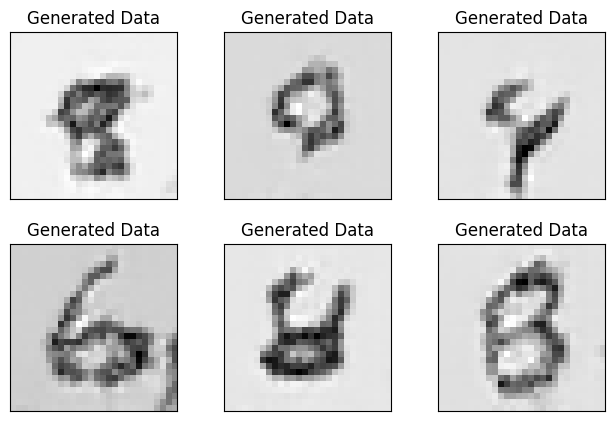

Epoch  10


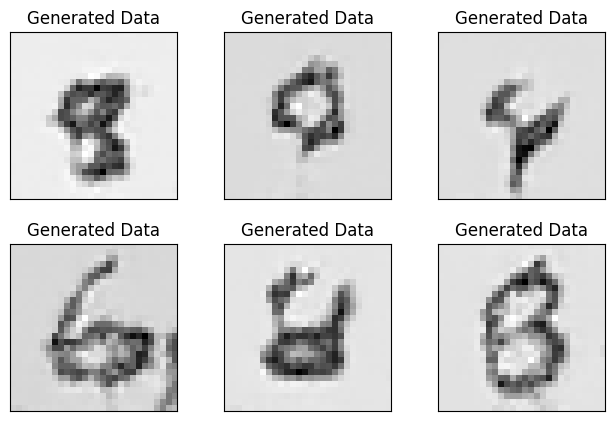

Epoch  11


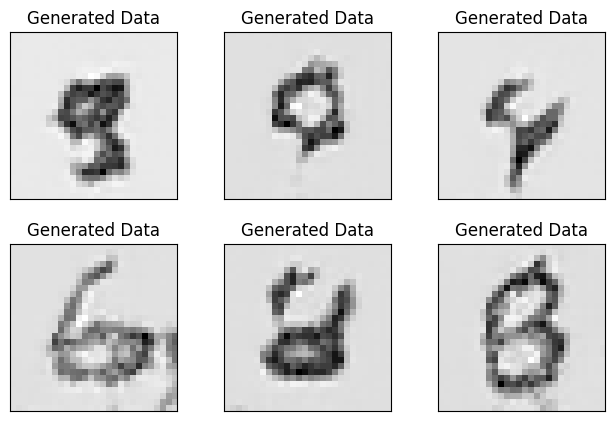

Epoch  12


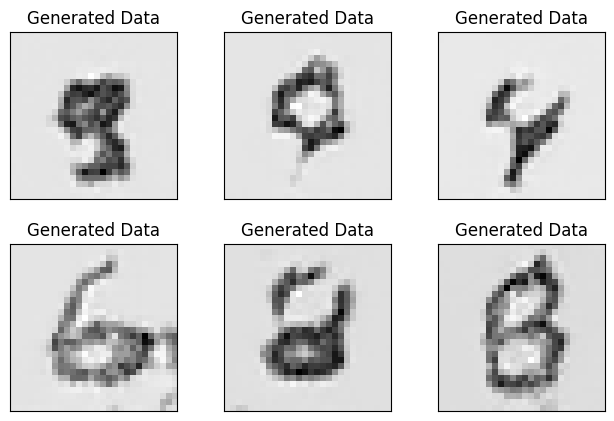

Epoch  13


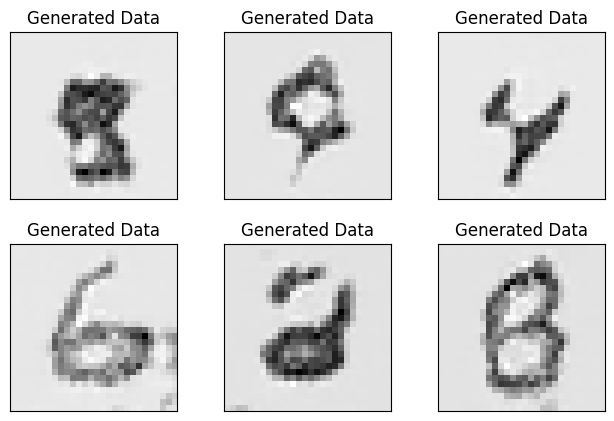

Epoch  14


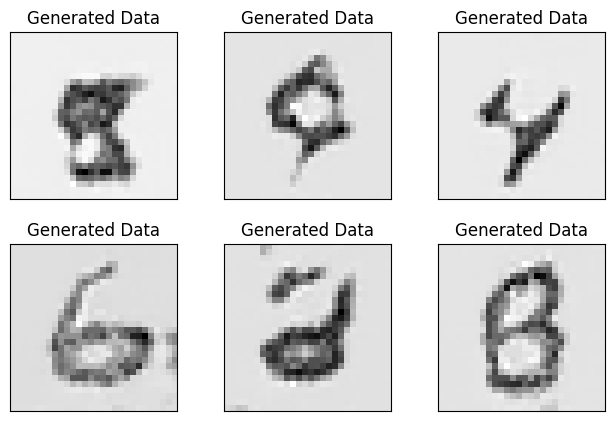

Epoch  15


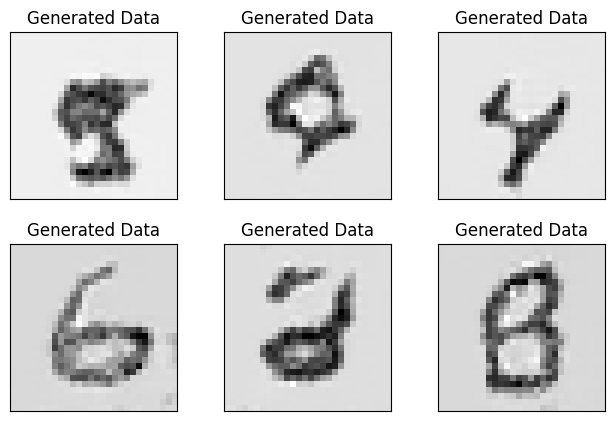

Epoch  16


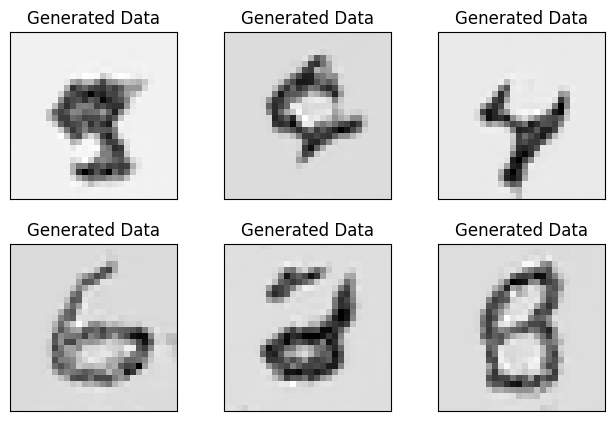

Epoch  17


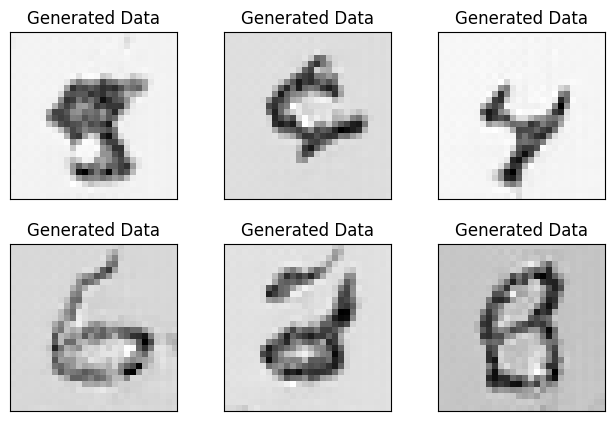

Epoch  18


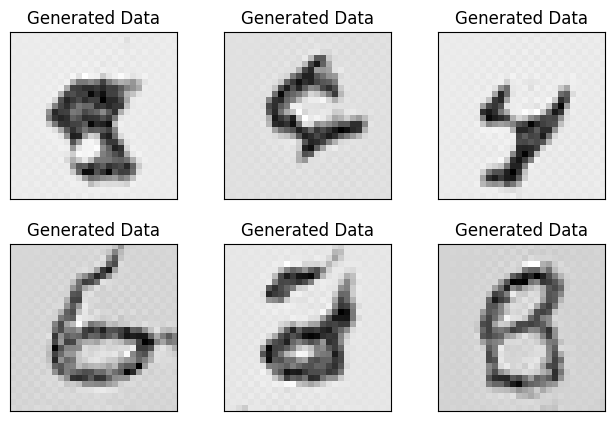

Epoch  19


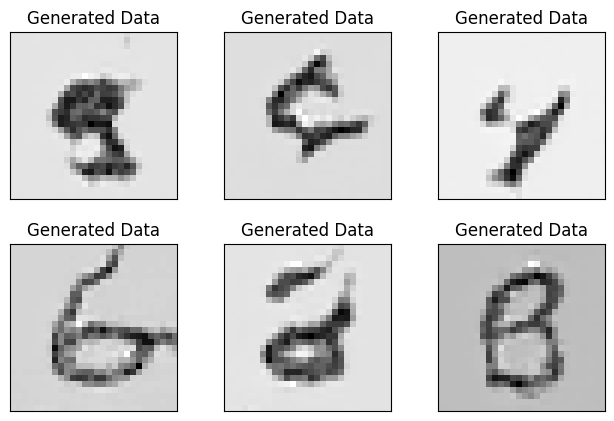

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [24]:
trainer = L.Trainer(max_epochs=20, accelerator='gpu', devices=AVAILABLE_GPUS)
trainer.fit(model, dm)

Epoch  20


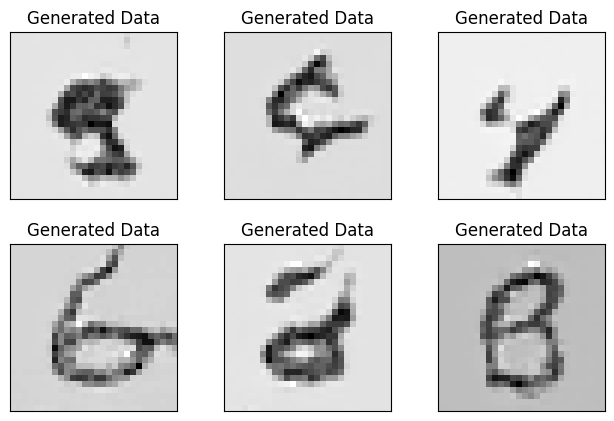

In [25]:
model.plot_images()